<h3>Introduction to Federated Learning</h3>

In traditional ML, the data to train the model must be gathered into a central location.
        <ul><li>This exposes it to privacy concerns</li><li>requires moving of data</li><li>and may limit what data can be used for training</li></ul>

In federated learning, the model can be trained without exposing the raw data of individuals.

To put it simply, a global model is sent to local data owners (distributed nodes) who train the model and send their parameters back to a central node, who then aggregates the model.

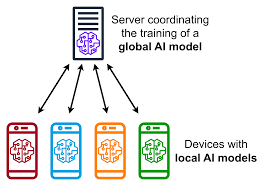

Typically an incentive mechanism is used to encourage data owners to contribute to training in FL.

<ul><li>However, since there is no method to see the data, there may be free riders.</li>

<li>There may also be adversaries who inject damaging parameters for malicious purposes.</li></ul>

In my project, I research an algorithm to try to identify and remove these weights that are submitted by free riders and malicious attackers.

Here are some of the results:

<ul><li>CDIM is training with my algorithm</li>
    <li>Benchmark is training using default algorithm</li>
    <li>Targeted/Random attacks are different attack strategies used by adversaries taken from federated learning literature</li></ul>

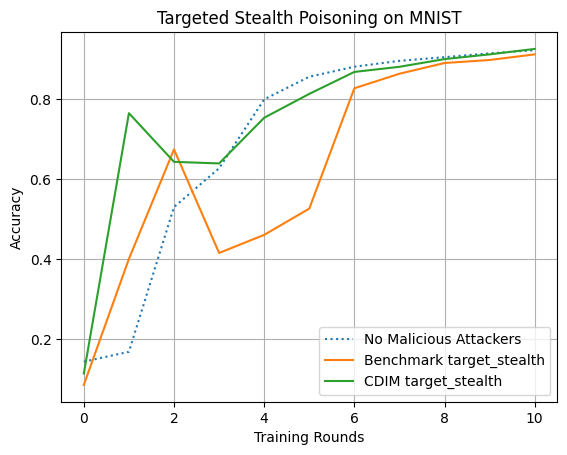
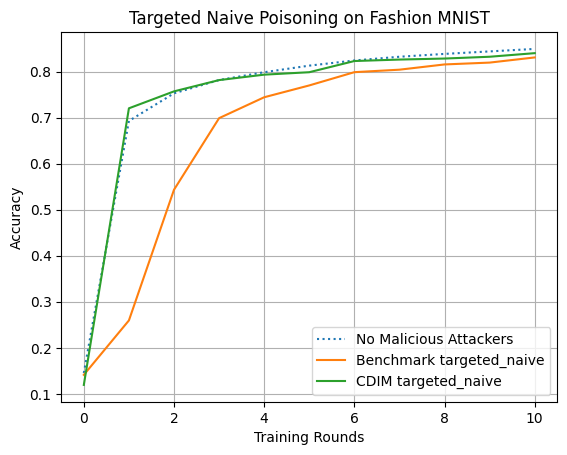
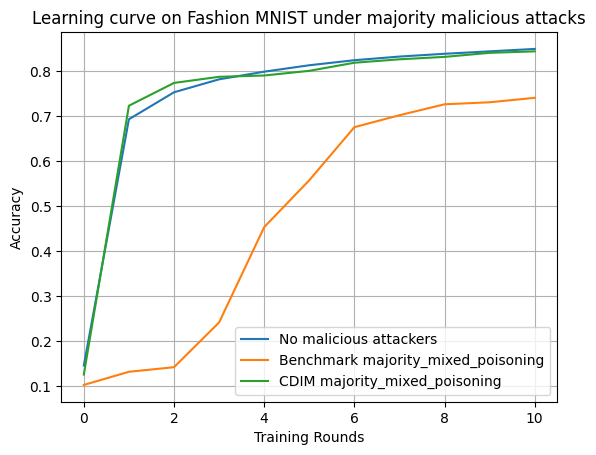


<h3>Importing modules</h3>

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.regularizers import l1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

GPU assist testing

In [36]:
#Debugging for GPU acceleration
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
try:
    with tf.device('/gpu:0'):
        print('GPU is available')
except tf.errors.InvalidArgumentError:
    print('GPU is NOT available')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU')]
GPU is available


<h3>The below implements the two main entities: central node and distributed nodes</h3>

In [1]:
import heapq
from collections import deque
import itertools 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

#Setup for CUDA - but code using GPU has been removed.
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

#A class that represents the central node in a Federated Learning setting
class Central:
    def __init__(self,bootstrap_n, budget, model, expected_number_of_participants):
        
        global global_df
        if(len(global_df) < bootstrap_n):
            print("Error occured, not enough data")
            return
        

        self.epochs = [2,2,2,2]
        self.epoch_ptr = 0

        self.budget = budget
        
        bootstrap_data = []
        for i in range(0,10):
            subset = global_df[global_df["Class"] == i]
            random_sample = subset.sample(bootstrap_n//10)
            bootstrap_data.append(random_sample)
        self.private_data = pd.concat(bootstrap_data)
        global_df = global_df.drop(self.private_data.index)
        #Split the data into train and test datasets, with an equal amount of both classes
        X = self.private_data.drop("Class", axis = 1)
        Y = self.private_data["Class"]
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.7, stratify = Y)
        
        #Scale and reshape data for use in training CNN
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_train = X_train.reshape(-1,28,28,1)
        X_test = X_test.reshape(-1,28,28,1)
        Y_train = keras.utils.to_categorical(Y_train, num_classes = 10)
        Y_test = keras.utils.to_categorical(Y_test, num_classes = 10)
        self.x_test = X_test
        self.y_test = Y_test
        self.threshold = 0
        
        self.model = model
        with tf.device('/gpu:0'):
            self.model.fit(X_train, Y_train, epochs = 3, validation_data = (X_test, Y_test), verbose = 0)

        #For clearing GPU memory
        keras.backend.clear_session()

        self.weights = self.model.get_weights()
        self.reward_matrix = dict()
        
        #Set reward for experiments.
        self.base_reward = budget/(expected_number_of_participants*100)
        
    
    #Function flattens list passed in
    def flatten(self, lst):
        flattened = []
        for item in lst:
            if isinstance(item, list):
                flattened.extend(self.flatten(item))
            elif isinstance(item, np.ndarray):
                flattened.extend(self.flatten(item))
            else:
                flattened.append(item)
        return flattened
    
    
    #More functions used in experiment | registering distributed nodes and broadcasting rewards
    def register(self, agent):
        if agent.id not in self.reward_matrix:
            self.reward_matrix[agent.id] = 0
    def broadcast(self):
        epochs = self.epochs[self.epoch_ptr]
        self.epoch_ptr+=1
        if(self.epoch_ptr==4):
          self.epoch_ptr = 0
        return self.model.get_weights(), self.base_reward, self.reward_matrix, epochs
    
    #Function for testing/benchmarking against default algorithm
    def naive_aggregate(self, participant_weights):
        flattened_pw = []
        for each in participant_weights:
            flattened_pw.append(self.flatten(each))
        
        final_weights = np.average([x for x in flattened_pw], axis = 0)
        
        #Update the weights of the model
        layer_shapes = [w.shape for w in self.model.get_weights()]
        layer_weights = []
        head = 0
        
        for shape in layer_shapes:
            size = np.prod(shape)
            current_weight = np.array(final_weights[head:head+size])
            layer_weights.append(current_weight.reshape(shape))
            head += size
        self.model.set_weights(layer_weights)

    
        
    
    #Function to update the global model with selected weights
    def update_model(self, final_weights):
        layer_shapes = [w.shape for w in self.model.get_weights()]
        layer_weights = []
        head = 0
        
        for shape in layer_shapes:
            size = np.prod(shape)
            current_weight = np.array(final_weights[head:head+size])
            layer_weights.append(current_weight.reshape(shape))
            head += size
        self.model.set_weights(layer_weights)
        
    
    #Evaluate performance of weights
    def evaluate(self, weights):
      eval_model = self.model
      final_weights = np.average([x for x in weights], axis = 0)
      
      #Update the weights of the model
      layer_shapes = [w.shape for w in self.model.get_weights()]
      layer_weights = []
      head = 0
      for shape in layer_shapes:
          size = (np.prod(shape))
          current_weight = np.array(final_weights[head:head+size])
          layer_weights.append(current_weight.reshape(shape))
          head += (size)
      eval_model.set_weights(layer_weights)

      return eval_model.evaluate(self.x_test, self.y_test, verbose = 0)[1]

        
    def strong_cluster(self, participant_weights, n_winners, p_ids):
      choice = 5
      selection_max = len(participant_weights) * 0.5
      while(True):
        no_doubles = 1
        if(len(participant_weights) < choice):
            print("clustering failed due to not enough participants")
            return
        kmeans = KMeans(n_clusters = choice, random_state = 0, n_init = 10)
        flattened_pw = []
        for each in participant_weights:
            flattened_pw.append(self.flatten(each))
        kmeans.fit(flattened_pw)
        
    
        labels = np.unique(kmeans.labels_)

        #Testing purposes only! Remove when not testing
        # Shows ID's of agents in each cluster
        label_list = [[] for i in range(max(kmeans.labels_) + 1)]
        indices = [[] for i in range(len(labels)+1)]
        scoring = [[] for i in range(len(labels)+1)]
        remaining_count = 0
        for i, label in enumerate(kmeans.labels_):
          label_list[label].append(i)
          indices[label].append(p_ids[i])
          scoring[label].append(i)
          remaining_count +=1
        print("clustering distribution", indices)
        
        
        accs = []
        for i in scoring:
          if(len(i) == 0):
            continue
          accs.append(self.evaluate([flattened_pw[x] for x in i]))
#         print("individual acc:", accs)
        #End of accuracy testing

        #Selecting winners
        
        #Remove worst cluster
        bottom_cluster = np.argmin(accs)
        removed_cluster = [x for x in label_list[bottom_cluster]]
        label_list[bottom_cluster] = []

        #Remove from the weightings at the end of the loop
        removal_list = [x for x in label_list if len(x)<=0.1*remaining_count]
        removal_list.append(removed_cluster)
        removed_labels = [i for i, x in enumerate(label_list) if len(x)<=0.1*remaining_count]
        
        labels = [x for x in labels if x not in removed_labels]
        
        removal_list = [x for i in removal_list for x in i]
        removal_list = sorted(removal_list, reverse= True)
        



        #Removing clusters with very few members - tau = 0.1n
        label_list = [x if len(x)>0.1*remaining_count else [] for x in label_list]



        #updating remaining count of participants
        remaining_count -= len(removal_list)

        #Count clusters remaining
        cluster_count = len(labels)
        #End clustering if no remaining clusters
        if(cluster_count == 0):
          print("Error occured, no remaining clusters")
          return

        #Need to recluster if cluster count is less than Z_min (we set Z_min to 3)
        if(cluster_count < 3 and remaining_count>5):
          print("reclustering")
          for i in removal_list:
            participant_weights.pop(i)
            p_ids.pop(i)
          continue

        #In case cluster count is now too small
        if(cluster_count<n_winners):
          n_winners = cluster_count

        #- -- - - - - - This section implements Shapley Value - - - -- -  -
        possible_coalitions = []
        for i in range(1, cluster_count+1):
            for combination in itertools.combinations(labels, i):
                possible_coalitions.append(combination)
        shapley = np.zeros(choice)
        for i in labels:
            for coalition in possible_coalitions:
                if i in coalition:
                    if(len(coalition)==1):
                        shapley[i]+= self.evaluate([flattened_pw[x] for x in label_list[i]])
                    else:
                        other_clusters = [label for label in coalition if label!=i]
                        other_clusters_pw = [flattened_pw[x] for c in other_clusters for x in label_list[c]]
                        full_coalition_pw = [flattened_pw[x] for c in coalition for x in label_list[c]]
                        marginal = self.evaluate(full_coalition_pw) - self.evaluate(other_clusters_pw)
                        shapley[i] += marginal
                        
        
        print("shapley: ", shapley)
        #------------- End of section that implements Shapley Value ------------
        selected_labels = [cluster_label for cluster_label in labels if shapley[cluster_label] > 0]
        selected_indices = [x for i in selected_labels for x in label_list[i]]
        winner_ids = [p_ids[i] for i in selected_indices]
        print("These are the winners", winner_ids)
        selected_parameters = [flattened_pw[x] for x in selected_indices]
        break
        

      final_weights = np.average([x for x in selected_parameters], axis = 0)
      
      #Update the weights of the model
      layer_shapes = [w.shape for w in self.model.get_weights()]
      layer_weights = []
      head = 0
      
      for shape in layer_shapes:
          size = np.prod(shape)
          current_weight = np.array(final_weights[head:head+size])
          layer_weights.append(current_weight.reshape(shape))
          head += size
      self.model.set_weights(layer_weights)
      successful_attacks = 0
      for j in winner_ids:
        if j<0:
            successful_attacks+=1
      print(successful_attacks)


        
    def get_model(self):
        return self.model
        
        
    
    
#Participant represents distributed nodes in a federated learning setting
class Participant:
    def __init__(self, data_size, participation_cost, identity, model):
        
        global global_df
        if(len(global_df) < data_size):
            print("Error occured, not enough data")
            return
        
        self.data_size = data_size
        self.participation_cost = participation_cost
        self.weights = []
        self.id = identity
        self.local_model = tf.keras.models.clone_model(model)
        self.epochs = 5
        
        bootstrap_data = []
        for i in range(0,10):
            subset = global_df[global_df["Class"] == i]
            random_sample = subset.sample(data_size//10)
            bootstrap_data.append(random_sample)
        self.private_data = pd.concat(bootstrap_data)
        global_df = global_df.drop(self.private_data.index)
        
        
    def test_data(self):
        print(self.data)

    #Need to make a function to decide whether participant will bid to take part in particular round
    def make_bid(self):
        return 0

    def train(self, model_weights, epochs):
        self.epochs = epochs
        self.local_model.set_weights(model_weights)
        self.local_model.compile(optimizer = Adam(learning_rate=0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])
               #Split the data into train and test datasets, with an equal amount of both classes
        X = self.private_data.drop("Class", axis = 1)
        Y = self.private_data["Class"]
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, stratify = Y)
        #scale data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_train = X_train.reshape(-1,28,28,1)
        X_test = X_test.reshape(-1,28,28,1)
        Y_train = keras.utils.to_categorical(Y_train, num_classes = 10)
        Y_test = keras.utils.to_categorical(Y_test, num_classes = 10)
        self.local_model.fit(X_train, Y_train,batch_size = 8, validation_data = (X_test, Y_test), epochs = self.epochs, verbose = 0)

        self.weights = []
        for layer in self.local_model.layers:
            layer_w = layer.get_weights()
            for w in layer_w:
                self.weights.append(w)
    
    def participate(self, round_reward):
        #A simple expected value to decide if it is worth participating - can change to more complicated model soon
        if(round_reward > self.participation_cost):
            return True
    
    def submit(self):
        return self.weights

    def getID(self):
      return self.id

class Free_Rider:
    
    def __init__(self, strategy, identity, model):
        self.id = identity
        self.strategy = strategy
        self.local_model = tf.keras.models.clone_model(model)
        #History used for delta weight attacks (estimate weight updates)
        self.history = None
    
    def participate(self, round_reward):
        return True
    
    def train(self, model_weights, epochs):
        self.local_model.set_weights(model_weights)
        self.local_model.compile(optimizer = Adam(learning_rate=0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])
        if self.strategy==1:
            #Simply return the global model weights - not used in experiments shown in conference paper
            self.weights = []
            for layer in self.local_model.layers:
                layer_w = layer.get_weights()
                for w in layer_w:
                    self.weights.append(w)
                    
        #Random arbitrary noise - not used in experiments shown in conference paper
        elif self.strategy == 2:
            #return the weights with some arbitrary noise added
            noise = random.uniform(random.randint(-15,0),random.randint(1,15))
            self.weights = []
            for layer in self.local_model.layers:
                    layer_w = layer.get_weights()
                    for w in layer_w:
                        self.weights.append(w+noise)
                        
        #Gaussian noise
        elif self.strategy == 3:
            #return the weights with some arbitrary Gaussian noise added
            self.weights = []
            for layer in self.local_model.layers:
                layer_w = layer.get_weights()
                for w in layer_w:
                    noisy_weights = random.normalvariate(w, w*random.uniform(0, 1.5))
                    self.weights.append(noisy_weights)
        
        #Delta weight attacks
        elif self.strategy == 4:
            if(self.history == None):
                self.history = tf.keras.models.clone_model(self.local_model)
                #not enough history yet
                self.weights = []
                for layer in self.local_model.layers:
                    layer_w = layer.get_weights()
                    for w in layer_w:
                        noisy_weights = random.normalvariate(w, w*random.uniform(0, 1.5))
                        self.weights.append(noisy_weights)
            else:
                self.weights = [] 
                previous_model = self.history
                for layer1, layer2 in zip(self.local_model.layers, previous_model.layers):
                    layer_w1 = layer1.get_weights()
                    layer_w2 = layer2.get_weights()
                    for w1, w2 in zip(layer_w1, layer_w2):
                        delta_weights = w1 + (w1-w2)
                        delta_noise = random.normalvariate(0, abs(w1-w2)/5)
                        self.weights.append(delta_weights + delta_noise)
            self.history.set_weights(model_weights)
                    
    def submit(self):
        return self.weights
      
    def getID(self):
      return self.id





NameError: name 'tf' is not defined

In federated learning, there may be adversaries who aim to destroy the model by submitting bad parameters!

<ul><li>They may have different attack strategies to avoid detection</li><li>and this is what I try to remove using my algorithm</li><ul>

In [38]:
#Adversary with different attack strategies
class MaliciousAgent:
    def __init__(self, data_size, model, strategy, poison_weight = 0.9, poison_ratio = 0.9, poison_label = 1, target_label=9):
        
        global global_df
        if(len(global_df) < 1000):
            print("Error occured, not enough data")
            return
        
        if(strategy == 0):
            self.id = -41
        elif(strategy == 1):
            self.id = -51
        elif(strategy == 2):
            self.id = -42
        elif(strategy == 3):
            self.id = -52
        elif(strategy == 4):
          self.id = -99
        
        self.target_label = target_label
        self.poison_ratio = poison_ratio
        self.poison_label = poison_label
        self.poison_weight = poison_weight
        self.strategy = strategy
        
        #regularization factor for stealth poisoning
        self.rho = 0.1
        
        self.history = None
        
        self.data_size = data_size
        self.participation_cost = 0
        self.weights = []
        self.local_model = tf.keras.models.clone_model(model)
        
        
        bootstrap_data = []
        for i in range(0,10):
            subset = global_df[global_df["Class"] == i]
            random_sample = subset.sample(data_size//10)
            bootstrap_data.append(random_sample)
        self.private_data = pd.concat(bootstrap_data)
        global_df = global_df.drop(self.private_data.index)
        self.private_data = self.private_data.reset_index(drop = True)
        
        self.X = self.private_data.drop("Class", axis = 1)
        self.Y = self.private_data["Class"]
        

    def getID(self):
        return self.id
    
    def participate(self, round_reward):
        return True
        
    
    def stealth_loss_function(self, y_true, y_pred):
        default_cross_entropy = categorical_crossentropy(y_true, y_pred)
        delta_prev = self.current_weights - self.history
        delta_mal = self.model.get_weights - self.current_weights 
        stealth_regularization = self.rho * np.linalg.norm(delta_mal - delta_prev)
        return default_cross_entropy + stealth_regularization
    
    def target_poison(self):
        Y = self.Y.copy()
        X = self.X.copy()
        target_idx = Y[Y == self.target_label].index.tolist()
        poisoned_idx = random.sample(target_idx, int(self.poison_ratio*len(target_idx)))
        weights = np.ones(self.data_size)
        
        for idx in poisoned_idx:
            Y[idx] = self.poison_label
            weights[idx] = self.poison_weight
        return X, Y, weights
    
    def random_poison(self):
        Y = self.Y.copy()
        X = self.X.copy()
        n_poisoned = int(self.poison_ratio*1*self.data_size)
        poisoned_idx = np.random.choice(Y.index, n_poisoned, replace = False)
        weights = np.ones(self.data_size)
        
        for idx in poisoned_idx:
            true_label = Y[idx]
            Y[idx] = random.choice([n for n in range(0,10) if n!=true_label])
            weights[idx] = self.poison_weight
        return X, Y, weights
        
        


    def train(self, model_weights, epochs):
        self.epochs = epochs
        self.current_weights = model_weights
        self.local_model.set_weights(model_weights)

        #Extreme attack
        if(self.strategy==4):
          self.weights = []
          for layer in self.local_model.layers:
            layer_w = layer.get_weights()
            for w in layer_w:
                self.weights.append(w+random.choice([-99999,99999]))
          return 

        #No stealth
        if(self.strategy == 0 or self.strategy == 1):
            self.local_model.compile(optimizer = Adam(learning_rate=0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])
        #Stealth
        else:
            self.local_model.compile(optimizer = Adam(learning_rate=0.001), loss = self.stealth_loss_function, metrics = ["accuracy"])
        
        #Poisoning attack/Targeted atttack
        if(self.strategy ==0 or self.strategy == 2):
            X_train, Y_train, weights_train = self.target_poison()
        #Random attack
        else:
            X_train, Y_train, weights_train = self.random_poison()
        
        X_train, X_test, Y_train, Y_test, weights_train, weights_test = train_test_split(X_train, Y_train,weights_train, test_size = 0.1)
        #scale data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_train = X_train.reshape(-1,28,28,1)
        X_test = X_test.reshape(-1,28,28,1)   
            
        Y_test = keras.utils.to_categorical(Y_test, num_classes = 10)    
        
        Y_train_categorical = keras.utils.to_categorical(Y_train, num_classes = 10)
        
        model.fit(X_train, Y_train_categorical, batch_size=16, epochs=self.epochs*2, validation_data=(X_test, Y_test),
                  sample_weight=weights_train, verbose = 0)

#         #explicit boosting
#         X_train, Y_train, weights_train = self.explicit_boost(X_train, Y_train, weights_train)
#         Y_train_categorical = to_categorical(Y_train)
        
#         model.fit(X_train, Y_train_categorical, batch_size=16, epochs=2, validation_data=(X_test, Y_test),
#                   sample_weight=weights_train, verbose = 0)
    
        self.weights = []
        for layer in self.local_model.layers:
            layer_w = layer.get_weights()
            for w in layer_w:
                self.weights.append(w)
    
    def submit(self):
        return self.weights
        
        

Functions below are used in experiments

In [39]:

def generate_participants(n_participants, cost_mean, cost_var, max_n, min_n, model):
    participants = []
    for i in range(n_participants):
        cost = 0
        data_n = random.randint(min_n, max_n)
        a = Participant(data_n, cost, i, model)
        participants.append(a)
    return participants

def generate_participants_CIFAR(n_participants, cost_mean, cost_var, max_n, min_n, model):
    participants = []
    for i in range(n_participants):
        cost = 0
        data_n = random.randint(min_n, max_n)
        a = Participant_CIFAR(data_n, cost, i, model)
        participants.append(a)
    return participants

#this is used to artificially add free riders to test the CLUSTERING procedure
def generate_free_riders(n, model):
    free_riders = []
    for i in range(math.floor(n/2)):
      fr = Free_Rider(4, -3, model)
      free_riders.append(fr)
    for i in range(math.ceil(n/2)):
      fr = Free_Rider(3, -2, model)
      free_riders.append(fr)
    return free_riders

def generate_free_riders_CIFAR(n, model):
    free_riders = []
    for i in range(math.floor(n/2)):
      fr = Free_Rider_CIFAR(4, -3, model)
      free_riders.append(fr)
    for i in range(math.ceil(n/2)):
      fr = Free_Rider_CIFAR(3, -2, model)
      free_riders.append(fr)
    return free_riders


def add_fr(distributed_nodes, n, model):
    fr = generate_free_riders(n, model)
    for each in fr:
        distributed_nodes.append(each)

def add_fr_CIFAR(distributed_nodes, n, model):
    fr = generate_free_riders_CIFAR(n, model)
    for each in fr:
        distributed_nodes.append(each) 

        
def generate_malicious_attackers(n, model):
    malicious_attackers = []
    if(n==1):
        m = MaliciousAgent(1000, model, 0)
        malicious_attackers.append(m)
        return malicious_attackers
    
    for i in range(math.floor(n/2)):
      m = MaliciousAgent(500, model, 0)
      malicious_attackers.append(m)
    for i in range(math.ceil(n/2)):
      m = MaliciousAgent(500, model, 1)
      malicious_attackers.append(m)
    return malicious_attackers

def generate_malicious_attackers_CIFAR(n, model):
    malicious_attackers = []
    if(n==1):
        m = MaliciousAgent_CIFAR(1000, model, 0)
        malicious_attackers.append(m)
        return malicious_attackers
    
    for i in range(math.floor(n/2)):
      m = MaliciousAgent_CIFAR(500, model, 0)
      malicious_attackers.append(m)
    for i in range(math.ceil(n/2)):
      m = MaliciousAgent_CIFAR(500, model, 1)
      malicious_attackers.append(m)
    return malicious_attackers

def add_ma_each(distributed_nodes, model):
    m1 = MaliciousAgent(500, model, 0)
    m2 = MaliciousAgent(500, model, 1)
    m3 = MaliciousAgent(500, model, 2)
    m4 = MaliciousAgent(500, model, 3)
    distributed_nodes.append(m1)
    distributed_nodes.append(m2)
    distributed_nodes.append(m3)
    distributed_nodes.append(m4)
    

def add_ma_general_naive(distributed_nodes, model):
  ma = MaliciousAgent(500, model, 1)
  distributed_nodes.append(ma)
def add_ma_target_naive(distributed_nodes, model):
  ma = MaliciousAgent(500, model, 0)
  distributed_nodes.append(ma)

def add_ma_naive(distributed_nodes, model):
  add_ma_general_naive(distributed_nodes, model)
  add_ma_target_naive(distributed_nodes, model)
  
def add_ma_general_stealth(distributed_nodes, model):
  ma = MaliciousAgent(500, model, 3)
  distributed_nodes.append(ma)
def add_ma_target_stealth(distributed_nodes, model):
  ma = MaliciousAgent(500, model, 2)
  distributed_nodes.append(ma)  
def add_ma_stealth(distributed_nodes, model):
  add_ma_general_stealth(distributed_nodes, model)
  add_ma_target_stealth(distributed_nodes, model)

def add_ma(distributed_nodes, n, model):
    ma = generate_malicious_attackers(n, model)
    for each in ma:
        distributed_nodes.append(each)
        
def add_ma_CIFAR(distributed_nodes, n, model):
    ma = generate_malicious_attackers_CIFAR(n, model)
    for each in ma:
        distributed_nodes.append(each)

def federated_round(central_node, distributed_nodes, n_winners):
    
    #Initialise new distributed nodes in central node
    for each in distributed_nodes:
        central_node.register(each)
    
    round_model, round_reward, reward_matrix, epochs = central_node.broadcast()
    round_participants = []
    #Distributed nodes decide if they wish to participate
    round_participants = distributed_nodes #for experiment, say they all participate.
    participant_weights = []
    participant_ids = []
    #Broadcast global round model and training for all participants
    for node in round_participants:
        node.train(round_model, epochs)
        participant_weights.append(node.submit())
        participant_ids.append(node.getID())
#     print("clustering")
    #Cluster, select winners, aggregate weights - May need to extend to add payments --> not sure if this is necssary
    central_node.strong_cluster(participant_weights, n_winners, participant_ids)
    

def naive_federated_round(central_node, distributed_nodes, n_winners):
    participant_weights = []
    participant_ids = []
    for each in distributed_nodes:
        central_node.register(each)
    round_model, round_reward, reward_matrix, epochs = central_node.broadcast()
    round_participants = random.sample(distributed_nodes, math.ceil(0.3*len(distributed_nodes)))
    for node in round_participants:
        node.train(round_model, epochs)
        participant_weights.append(node.submit())
        participant_ids.append(node.getID())
    central_node.naive_aggregate(participant_weights)

def n_rounds(n, central_node, distributed_nodes, n_winners):
    accuracies = []
    for i in range(0,n):
        federated_round(central_node, distributed_nodes, n_winners)
        acc = test(central_node)
        accuracies.append(acc)
    return accuracies

def n_rounds_CIFAR(n, central_node, distributed_nodes, n_winners):
    accuracies = []
    for i in range(0,n):
        federated_round(central_node, distributed_nodes, n_winners)
        acc = test_CIFAR(central_node)
        accuracies.append(acc)
    return accuracies


def naive_rounds(n, central_node, distributed_nodes, n_winners):
    accuracies = []
    for i in range(0,n):
        naive_federated_round(central_node, distributed_nodes, n_winners)
        acc = test(central_node)
        accuracies.append(acc)
    return accuracies

def naive_rounds_CIFAR(n, central_node, distributed_nodes, n_winners):
    accuracies = []
    for i in range(0,n):
        naive_federated_round(central_node, distributed_nodes, n_winners)
        acc = test_CIFAR(central_node)
        accuracies.append(acc)
    return accuracies

def n_rounds_fd(n, central_node, distributed_nodes, n_winners):
    accuracies = []
    for i in range(0,n):
        federated_round(central_node, distributed_nodes, n_winners)
        acc = test_fraud_detection(central_node)
        if(acc>=90):
          print("Converged to 90 in ", i)
          break
        accuracies.append(acc)
    return accuracies

#testing purposes only
def test(central_node):
    test_x = test_df.drop("Class", axis = 1).to_numpy()
    test_y = test_df["Class"]
    scaler = StandardScaler()
    test_x = scaler.fit_transform(test_x)
    test_x = test_x.reshape(-1,28,28,1)
    test_y = keras.utils.to_categorical(test_y, num_classes = 10)
    local_model = central_node.get_model()
    loss, accuracy = local_model.evaluate(test_x, test_y)
    print(loss, accuracy)
    return accuracy

def test_CIFAR(central_node):
    test_x = test_df.drop("Class", axis = 1).to_numpy()
    test_y = test_df["Class"]
    scaler = StandardScaler()
    test_x = scaler.fit_transform(test_x)
    test_x = np.reshape(test_x, (test_x.shape[0], 32, 32, 3))
    test_y = keras.utils.to_categorical(test_y, num_classes = 10)
    local_model = central_node.get_model()
    loss, accuracy = local_model.evaluate(test_x, test_y)
    print(loss, accuracy)
    return accuracy

def test_fraud_detection(central_node):
    test_x = test_df.drop("Class", axis = 1).to_numpy()
    test_y = test_df["Class"]
    scaler = StandardScaler()
    test_x = scaler.fit_transform(test_x)
    test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)
    local_model = central_node.get_model()
    loss, accuracy = local_model.evaluate(test_x, test_y)
    print(loss, accuracy)
    return accuracy


<h3>The models used in experiments. Calling the function sets up the model for the respective dataset </h3>

In [42]:
def call_mnist():
    global global_df
    global test_df
    global model
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape((X_train.shape[0], -1))
    X_test = X_test.reshape((X_test.shape[0], -1))

    # X_train = X_train/255.0
    # X_test = X_test /255.0

    global_df = pd.DataFrame(X_train)
    global_df['Class'] = y_train
    test_df = pd.DataFrame(X_test)
    test_df['Class'] = y_test

    reshape_form_train = (28,28)
    reshape_form_test = (28,28)

    # scaler = StandardScaler()
    # scaled_X_train = scaler.fit_transform(X_train)
    # scaled_X_train = scaled_X_train.reshape(reshape_form_train)

    model = Sequential()
    model.add(Conv2D(32, (3,3) ,activation = "relu", input_shape = (28,28,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, (3,3) ,activation = "relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())

    model.add(Dense(128,activation = "relu", kernel_regularizer=l1(0.2)))
    model.add(Dense(10, activation = "softmax"))
    model.summary()
    model.compile(optimizer = Adam(learning_rate=0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [44]:
def call_fashion_mnist():
    global global_df
    global test_df
    global model
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    X_train = X_train.reshape((X_train.shape[0], -1))
    X_test = X_test.reshape((X_test.shape[0], -1))

    # X_train = X_train/255.0
    # X_test = X_test /255.0

    global_df = pd.DataFrame(X_train)
    global_df['Class'] = y_train
    test_df = pd.DataFrame(X_test)
    test_df['Class'] = y_test

    reshape_form_train = (28,28)
    reshape_form_test = (28,28)

    # scaler = StandardScaler()
    # scaled_X_train = scaler.fit_transform(X_train)
    # scaled_X_train = scaled_X_train.reshape(reshape_form_train)

    model = Sequential()
    model.add(Conv2D(32, (3,3) ,activation = "relu", input_shape = (28,28,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3,3) ,activation = "relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(128, (3,3) ,activation = "relu"))
    model.add(BatchNormalization())
    model.add(Flatten())

    # model.add(Dense(128,activation = "relu", kernel_regularizer=l1(0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(128,activation = "relu", kernel_regularizer=l1(0.1)))
    # model.add(Dropout(0.5))

    model.add(Dense(10, activation = "softmax"))
    model.summary()
    model.compile(optimizer = Adam(learning_rate=0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])

<h2>Generate central node and distributed nodes to be participants </h2>

Below are functions that allow for easy experimentation and configuration of parameters within each type of experiment.

In [45]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score


def free_rider_experimental(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_fr(distributed_nodes, math.ceil(n_participants*percentage), model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)
  rounds = list(range(1, len(accuracies) + 1))
  plt.plot(rounds, accuracies)
  plt.grid(True)
  plt.xlabel('Training rounds')
  plt.ylabel('Accuracy')
  plt.show()
    
def free_rider_experimental_many(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 300, min_n = 300, model = model)
  add_fr(distributed_nodes, math.ceil(n_participants*percentage), model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)
  rounds = list(range(1, len(accuracies) + 1))

def naive_free_rider_experimental(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_fr(distributed_nodes, math.ceil(n_participants*percentage), model)
  accuracies = naive_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)
  rounds = list(range(1, len(accuracies) + 1))
  plt.plot(rounds, accuracies)
  plt.grid(True)
  plt.xlabel('Training rounds')
  plt.ylabel('Accuracy')
  plt.show()

def naive_free_rider_experimental_CIFAR(model, percentage, n_participants, max_rounds):
  central_node = Central_CIFAR(300, 100000000, model, n_participants)
  test_CIFAR(central_node)
  distributed_nodes = generate_participants_CIFAR(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_fr_CIFAR(distributed_nodes, math.ceil(n_participants*percentage), model)
  accuracies = naive_rounds_CIFAR(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)


def free_rider_experimental_CIFAR(model, percentage, n_participants, max_rounds):
  central_node = Central_CIFAR(300, 100000000, model, n_participants)
  test_CIFAR(central_node)
  distributed_nodes = generate_participants_CIFAR(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_fr_CIFAR(distributed_nodes, math.ceil(n_participants*percentage), model)
  accuracies = n_rounds_CIFAR(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)
  rounds = list(range(1, len(accuracies) + 1))
  plt.plot(rounds, accuracies)
  plt.grid(True)
  plt.xlabel('Training rounds')
  plt.ylabel('Accuracy')
  plt.show()
    
def free_rider_experimental_fraud(model, percentage, n_participants, max_rounds):
  central_node = Central(100, 100000000, model, n_participants)
  test_fraud_detection(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 1000, min_n = 200, model = model)
  add_fr(distributed_nodes, math.ceil(n_participants*percentage), model)
  accuracies = n_rounds_fd(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)
  plt.plot(rounds, accuracies)
  plt.grid(True)
  plt.xlabel('Training rounds')
  plt.ylabel('Accuracy')
  plt.show()

def free_rider_ma_experimental(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 4000, min_n = 4000, model = model)
  add_fr(distributed_nodes, math.ceil(n_participants*percentage), model)
  add_ma(distributed_nodes, 1, model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)
  rounds = list(range(1, len(accuracies) + 1))
  plt.plot(rounds, accuracies)
  plt.xlabel('Training rounds')
  plt.ylabel('Accuracy')
  plt.show()


def every_ma_experimental(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 1000, min_n = 1000, model = model)
  add_fr(distributed_nodes, math.ceil(n_participants*percentage), model)
  add_ma_each(distributed_nodes, model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)
  rounds = list(range(1, len(accuracies) + 1))
  plt.plot(rounds, accuracies)
  plt.xlabel('Training rounds')
  plt.ylabel('Accuracy')
  plt.show()

def ma_experimental(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_each(distributed_nodes, model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_experimental_naive(model, percentage,  n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_each(distributed_nodes, model)
  accuracies = naive_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)


def ma_non_stealth(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_naive(distributed_nodes, model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_stealth(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_stealth(distributed_nodes, model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_target_visible(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_target_naive(distributed_nodes, model)
  add_ma_target_naive(distributed_nodes, model)
  add_ma_target_naive(distributed_nodes, model)
  add_ma_target_naive(distributed_nodes, model)
  add_ma_target_naive(distributed_nodes, model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_target_stealth(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_target_stealth(distributed_nodes, model)
  add_ma_target_stealth(distributed_nodes, model)
  add_ma_target_stealth(distributed_nodes, model)
  add_ma_target_stealth(distributed_nodes, model)
  add_ma_target_stealth(distributed_nodes, model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_random_visible(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_general_naive(distributed_nodes, model)
  add_ma_general_naive(distributed_nodes, model)
  add_ma_general_naive(distributed_nodes, model)
  add_ma_general_naive(distributed_nodes, model)
  add_ma_general_naive(distributed_nodes, model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_random_stealth(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_general_stealth(distributed_nodes, model)
  add_ma_general_stealth(distributed_nodes, model)
  add_ma_general_stealth(distributed_nodes, model)
  add_ma_general_stealth(distributed_nodes, model)
  add_ma_general_stealth(distributed_nodes, model)
  accuracies = n_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_benchmark_general_naive(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_general_naive(distributed_nodes, model)
  add_ma_general_naive(distributed_nodes, model)
  add_ma_general_naive(distributed_nodes, model)
  add_ma_general_naive(distributed_nodes, model)
  add_ma_general_naive(distributed_nodes, model)
  accuracies = naive_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_benchmark_target_naive(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_target_naive(distributed_nodes, model)
  add_ma_target_naive(distributed_nodes, model)
  add_ma_target_naive(distributed_nodes, model)
  add_ma_target_naive(distributed_nodes, model)
  add_ma_target_naive(distributed_nodes, model)
  accuracies = naive_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_benchmark_general_stealth(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_general_stealth(distributed_nodes, model)
  add_ma_general_stealth(distributed_nodes, model)
  add_ma_general_stealth(distributed_nodes, model)
  add_ma_general_stealth(distributed_nodes, model)
  add_ma_general_stealth(distributed_nodes, model)
  accuracies = naive_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def ma_benchmark_target_stealth(model, percentage, n_participants, max_rounds):
  central_node = Central(300, 100000000, model, n_participants)
  test(central_node)
  distributed_nodes = generate_participants(n_participants = math.ceil(n_participants*(1-percentage)),cost_mean = 10, cost_var = 1 , max_n = 2500, min_n = 2500, model = model)
  add_ma_target_stealth(distributed_nodes, model)
  add_ma_target_stealth(distributed_nodes, model)
  add_ma_target_stealth(distributed_nodes, model)
  add_ma_target_stealth(distributed_nodes, model)
  add_ma_target_stealth(distributed_nodes, model)
  accuracies = naive_rounds(max_rounds, central_node, distributed_nodes, 3)
  print("list of accuracies over rounds", accuracies)

def check_poisoning(model, dataset):
  test_x = test_df.drop("Class", axis = 1).to_numpy()
  test_y = test_df["Class"]
  scaler = StandardScaler()
  test_x = scaler.fit_transform(test_x)
  if(dataset == 'mnist'):
    poison_label = 1
    target_label = 9
    test_x = test_x.reshape(-1,28,28,1)
  elif(dataset == 'fashion_mnist'):
    poison_label = 7
    target_label = 9
    test_x = test_x.reshape(-1,28,28,1)
  else:
    poison_label = 1
    target_label = 9 
    np.reshape(test_x, (test_x.shape[0], 32, 32, 3))

  y_pred = model.predict(test_x)
  y_pred = np.argmax(y_pred, axis = 1)
  y_true = test_y
  target_labels = ['0','1','2','3','4','5','6','7','8','9']
  print(classification_report(y_true, y_pred, target_names=target_labels))